<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/%E4%BF%AE%E6%AD%A3applewatch_ecg_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

!pip install biosppy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from biosppy.signals import ecg

## データの読み込み

In [ ]:
uploaded = files.upload()

Saving ecg_2021-10-05_2.csv to ecg_2021-10-05_2 (1).csv


In [ ]:
ecg_df = pd.read_csv(list(uploaded.keys())[0], skiprows=13, header=None)

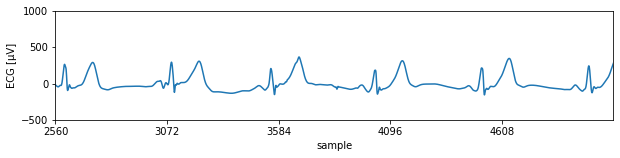

In [ ]:
fig = plt.figure(figsize=(10,2))

plt.plot(ecg_df[0])
plt.xlabel('sample')
plt.xlim(512 * 5, 512 * 10)
plt.xticks(np.arange(512 * 5, 512 * 10, 512))
plt.ylabel('ECG [μV]')
plt.ylim(-500, 1000)


plt.show()




## BioSPPy

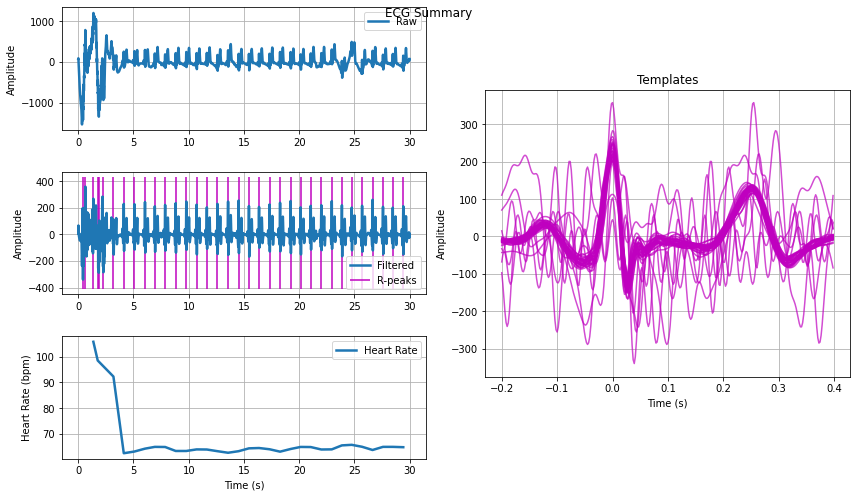

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 864x504 with 0 Axes>

In [90]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import files
plt.rcParams['figure.figsize'] = [12, 7]


ecg_data=ecg.ecg(signal=ecg_df[0], sampling_rate=512., show=True)

pd.DataFrame(ecg_data).to_csv('ecg.csv')
files.download("ecg.csv")

plt.savefig("file_name.jpeg",dpi=500,bbox_inches="tight")
files.download("file_name.jpeg")

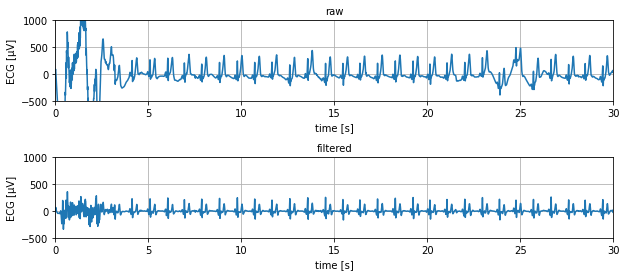

In [ ]:
(ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate) = ecg_data

fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.7)

for (i, data, title) in [(1, ecg_df[0], 'raw'), (2, filtered, 'filtered')]:
    ax = fig.add_subplot(2, 1, i)
    ax.plot(ts, data)
    ax.set_title(title, fontsize=10)
    ax.set_xlim(0, 30)
    ax.set_ylim(-500, 1000)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('ECG [μV]')
    ax.grid()

plt.show()
  


## R波ピーク検出

In [ ]:
(ts, filtered, _, _, _, _, _,) = ecg.ecg(signal=ecg_df[0], sampling_rate=512., show=False)

rpeaks_christov, = ecg.christov_segmenter(filtered, 512.)
rpeaks_engzee, = ecg.engzee_segmenter(filtered, 512.)
rpeaks_gamboa, = ecg.gamboa_segmenter(filtered, 512.)
rpeaks_hamilton, = ecg.hamilton_segmenter(filtered, 512.)
rpeaks_ssf, = ecg.ssf_segmenter(filtered, 512.)
rpeaks_ssf_2000, = ecg.ssf_segmenter(filtered, 512., threshold=2000.)

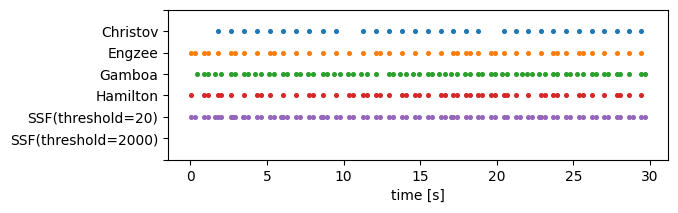

In [ ]:
fig = plt.figure(figsize=(5, 1.5), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])

scatter_rpeaks = lambda y, peaks: ax.scatter(ts[peaks], np.tile(y, len(peaks)), s=7)
scatter_rpeaks(1, rpeaks_christov)
scatter_rpeaks(2, rpeaks_engzee)
scatter_rpeaks(3, rpeaks_gamboa)
scatter_rpeaks(4, rpeaks_hamilton)
scatter_rpeaks(5, rpeaks_ssf)
scatter_rpeaks(6, rpeaks_ssf_2000)

ax.set_xlabel('time [s]')
ax.set_yticks(np.arange(8))
ax.set_yticklabels(['', 'Christov', 'Engzee', 'Gamboa', 'Hamilton', 'SSF(threshold=20)', 'SSF(threshold=2000)'])
ax.invert_yaxis()

## RRI

In [ ]:
ts_peaks = ts[rpeaks_christov]
rri = np.diff(ts_peaks) * 1000

import scipy
spline_func = scipy.interpolate.interp1d(ts_peaks[:-1], rri, kind='cubic')
ts_1sec = np.arange(ts_peaks[0], ts_peaks[-2], 1)
rri_1sec = spline_func(ts_1sec).round(6)

ValueError: ignored

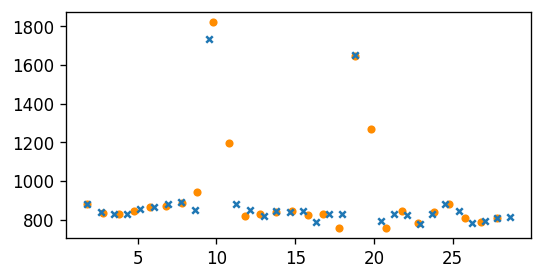

In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=120)

plt.scatter(ts_peaks[:-1], rri, marker='x', s=15, label='RRI', zorder=2)
plt.scatter(ts_1sec, rri_1sec, s=15, color='darkorange', label='RRI (interpolated)')
x = np.arange(0.9, 28.8, 0.05)
plt.plot(x, spline_func(x), color='darkorange', lw=1, zorder=-1)

plt.xlabel('time [s]')
plt.ylabel('RRI [ms]')
plt.xlim(0, 30)
plt.ylim(880, 1080)
plt.grid()
plt.legend()

## RRV (SDNN)

In [ ]:
np.std(rri_1sec) # ms

253.59519707886278

In [ ]:
!pip install hrv
from hrv.classical import frequency_domain
from hrv.rri import RRi

results = frequency_domain(
  rri=RRi(rri_1sec), # この記事の方法で算出した1秒周期のRRI
  fs=4.0,
  method='welch',
  interp_method='cubic',
  detrend='linear'
)
print(results)

     |████████████████████████████████| 228 kB 7.1 MB/s 
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234836 sha256=f57ce80eeba9875cffea4fb33c40fa5251e1364eed7dada4ef49afd69ba37a67
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built spectrum
{'total_power': 79031.27311008543, 'vlf': 0.0, 'lf': 41538.8568553414, 'hf': 37492.41625474403, 'lf_hf': 1.1079269090875241, 'lfnu': 52.56002493782489, 'hfnu': 47.43997506217511}


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 99, using nperseg = 99
  .format(nperseg, input_length))
